## Predição da produtividade da cana-de-açúcar no estado de São Paulo

#### Parte 1: Análise exploratória e limpeza de dados de produtividade da cana-de-açúcar obtidos da página do IBGE

Nessa primeira parte iremos analisar os dados de produtividade para cada município. Os pasos consistem em separar o csv original em cada uma das tabelas e preencher os valores ausentes

In [108]:
# Carregar libraries
import numpy as np
import pandas as pd
import unicodecsv as csv
import matplotlib.pyplot as plt
import missingno
import sys
import warnings
from estrategia1 import *
from estrategia2 import *
from estrategia3 import *
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [146]:
# Carregar dados e criar 'chunks' para cada tabela. Salvar separadamente no computador
for i, chunk in enumerate(pd.read_csv('tabela1612.csv',  encoding ='ISO-8859-1', decimal = ',', sep = ';', chunksize=648)):
    chunk.to_csv('chunk{}.csv'.format(i), index=False, encoding ='ISO-8859-1', decimal = '.')

No final da tabela original temos as descrições seguintes:

  - Zero absoluto, não resultante de um cálculo ou arredondamento (-) 
  - Zero resultante de um cálculo ou arredondamento (0)
  - Valor não se aplica. Ex: Não se pode obter o total da produção agrícola em determinado município quando os produtos agrícolas são contabilizados com unidades de medida distintas (..)
  - Valor não disponível. Ex: A produção de feijão em determinado município não foi pesquisada ou determinado município não existia no ano da pesquisa (...)
  
Após conferir os dados de produtividade com os dados de área plantada, foi possível observar que os municípios que não tem valores numéricos e apresentam algum dos símbolos mencionados acima, não possuem valor de produtivade por algúm dos motivos já mencionados, más principalmente porque não houve registro de área plantada. Então, iremos utilizar duas estratégias, sendo que a primeira será reemplazar todos os símbolos com espaço ou branco ou NaN que depois será preenchido com a média, para completar todos os espaços. A segunda estratégia será utilizar os dados com os NaNs.

O primeiro paso então é substituir os símbolos por 'NaN'


In [6]:
# Carregar a tabela que contem a produtividade da cana de açúcar para cada ano. Excluir as primeiras 4 linhas e as ultimas 2.
lista_ausentes = ['-', '..', '...']
dat = pd.read_csv("chunk5.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,3500105,Adamantina (SP),50000,80000,76311,77794,80000,81307,75000,100000,...,75000,60000,70000,60000,80000,80000,80000,70000,75000,70000
2,3500204,Adolfo (SP),NaN,80000,NaN,NaN,120000,89009,100000,100000,...,90000,90000,90000,70000,70000,80000,90000,90000,90000,90000
3,3500303,Aguaí (SP),80000,NaN,87000,86089,86000,85434,85000,85000,...,90000,90000,100000,100000,80000,90000,90000,85000,85000,85000
4,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000,90000,90000,90000,NaN,NaN,NaN,NaN,NaN,NaN
5,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dat.shape

(642, 23)

In [8]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 1 to 642
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Cód.       642 non-null    object
 1   Município  642 non-null    object
 2   2000       381 non-null    object
 3   2001       383 non-null    object
 4   2002       418 non-null    object
 5   2003       421 non-null    object
 6   2004       438 non-null    object
 7   2005       450 non-null    object
 8   2006       467 non-null    object
 9   2007       483 non-null    object
 10  2008       506 non-null    object
 11  2009       500 non-null    object
 12  2010       521 non-null    object
 13  2011       530 non-null    object
 14  2012       491 non-null    object
 15  2013       516 non-null    object
 16  2014       511 non-null    object
 17  2015       508 non-null    object
 18  2016       512 non-null    object
 19  2017       514 non-null    object
 20  2018       519 non-null    objec

Todas as colunas foram lidas como 'object'. Por isso precisamos converter para numerico

In [9]:
# Selecionar as colunas a converter
cols = dat.columns.drop(["Cód.", "Município"])
cols

Index(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020'],
      dtype='object')

In [171]:
# Converter colunas para tipo numerico
dat[cols] = dat[cols].apply(pd.to_numeric, errors = 'coerce')
dat.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
2,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
3,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
4,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.0,90000.0,90000.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN
5,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
dat.shape

(642, 23)

In [12]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 1 to 642
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Cód.       642 non-null    object 
 1   Município  642 non-null    object 
 2   2000       381 non-null    float64
 3   2001       383 non-null    float64
 4   2002       418 non-null    float64
 5   2003       421 non-null    float64
 6   2004       438 non-null    float64
 7   2005       450 non-null    float64
 8   2006       467 non-null    float64
 9   2007       483 non-null    float64
 10  2008       506 non-null    float64
 11  2009       500 non-null    float64
 12  2010       521 non-null    float64
 13  2011       530 non-null    float64
 14  2012       491 non-null    float64
 15  2013       516 non-null    float64
 16  2014       511 non-null    float64
 17  2015       508 non-null    float64
 18  2016       512 non-null    float64
 19  2017       514 non-null    float64
 20  2018      

In [13]:
# Descrever os dados
dat.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,381.000000,383.000000,418.000000,421.000000,438.000000,450.000000,467.000000,483.000000,506.000000,500.000000,...,530.000000,491.000000,516.000000,511.000000,508.000000,512.000000,514.000000,519.000000,518.000000,515.000000
mean,75104.435696,75308.028721,76572.440191,77986.137767,78883.949772,79697.422222,82600.933619,82760.086957,81830.237154,83436.128000,...,80818.015094,77962.959267,79305.798450,72675.874755,76010.992126,78120.646484,78526.655642,76118.510597,75444.432432,76552.504854
std,14495.151189,13403.233625,13235.901627,16007.396004,12854.484601,14299.738869,18373.835703,16359.525897,15927.510433,18037.357172,...,14442.579189,10483.770858,11879.309913,11713.637097,12066.415642,12746.845468,12467.961083,14014.284852,12272.952003,12128.665299
min,10000.000000,10000.000000,30000.000000,21676.000000,30000.000000,11955.000000,14000.000000,13000.000000,9000.000000,75.000000,...,100.000000,20819.000000,1200.000000,20000.000000,20000.000000,10000.000000,10000.000000,2000.000000,2000.000000,2000.000000
25%,70000.000000,70000.000000,70000.000000,70000.000000,71564.250000,74497.000000,75000.000000,75000.000000,75000.000000,78932.500000,...,74000.000000,70157.500000,73000.000000,65430.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
50%,75000.000000,77931.000000,80000.000000,80000.000000,80000.000000,79475.000000,80000.000000,80000.000000,81202.500000,83656.000000,...,80000.000000,80000.000000,80000.000000,71604.000000,75000.000000,80000.000000,80000.000000,79223.000000,75000.000000,78000.000000
75%,80000.000000,80000.000000,83913.500000,85000.000000,85856.250000,89396.000000,90000.000000,90000.000000,90000.000000,90000.000000,...,90000.000000,85000.000000,85000.000000,80000.000000,80000.000000,85000.000000,85000.000000,85000.000000,80000.000000,82000.000000
max,150000.000000,130000.000000,124900.000000,170764.000000,120000.000000,119423.000000,250000.000000,150000.000000,130000.000000,165000.000000,...,125000.000000,112073.000000,120049.000000,120000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000


Na tabela acima podemos observar que não temos dados para todos os Municípios em todos os anos. Se completo, deveria ser 642 na linha 'count'; porém vemos que há muitos dados faltantes. Como esses dados ausentes são produtos da não produção de cana naquele ano ou naquele municipio, a unica forma que podemos preencher é estudando as médias ou medianas por ano e por municipio. 

In [25]:
# Verifica o percentual de valores ausentes
# Função do módulo estratégia 1
func_calc_percentual_valores_ausentes(dat)

O dataset tem 22.89 % de valores ausentes.


In [26]:
func_calc_percentual_valores_ausentes_coluna(dat)      

O dataset tem 23 colunas.
Encontrado: 21 colunas que têm valores ausentes.


,Valores Ausentes,% de Valores Ausentes,Dtype
2000,261,40.65,float64
2001,259,40.34,float64
2002,224,34.89,float64
2003,221,34.42,float64
2004,204,31.78,float64
2005,192,29.91,float64
2006,175,27.26,float64
2007,159,24.77,float64
2012,151,23.52,float64
2009,142,22.12,float64


In [27]:
func_calc_percentual_valores_ausentes_linha(dat)

51.09 % das linhas no conjunto de dados contêm pelo menos um valor ausente.


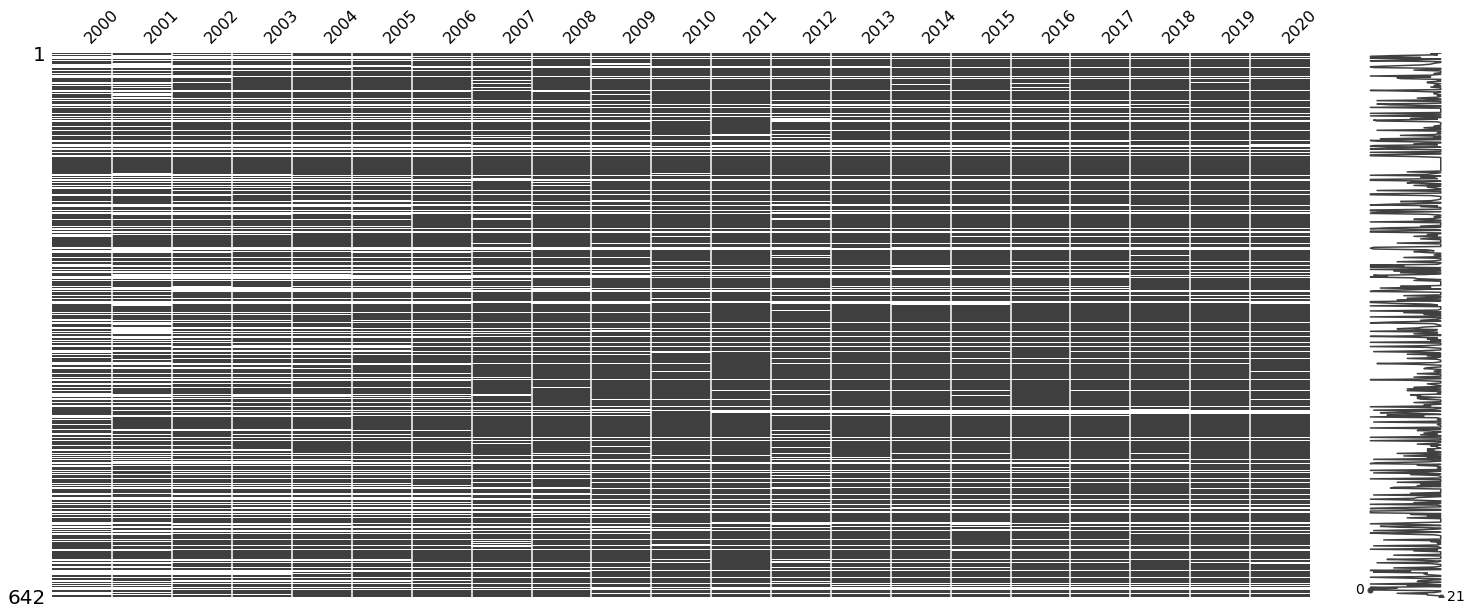

In [84]:
# Plot - Mapa de Valores Ausentes
dat_nan = pd.DataFrame(dat.isna().sum())

if dat.isna().any(axis = None):
    missingno.matrix(dat[dat_nan[dat_nan[0]>0].index])
    plt.show()

Temos um padrão de variação nos dados. Há linhas inteiras com células vazias, o que quer dizer que vários municípios não produziram cana-de-açucar em nenhum dos anos estudados. Então, o paso seguinte é identificar a porcentagem desses valores ausentes em cada linha e coluna. A princípio iremos focar em deletar os valores ausentes nas linhas. Adotaremos a estratégia de eliminar municípios com mais de 40% de dados ausentes.

O que precisams fazer agora é contar os valores nulos para cada município, para ter certeza se são somente alguns valores faltando ou a porcentagem é maior. Se os valores ausentes em cada município representarem mais de 40%, o município será excluído da análise

In [87]:
# Contar as linhas com valores ausentes
missing_rows = sum([True for idx,row in dat.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes". format(missing_rows))

Temos 328 linhas com valores ausentes


In [89]:
## Criar um dataframe com o cálculo da porcentagem de valores ausentes para cada linha
rows_missing = dat.isnull().sum(axis=1)
rows_perc = round(((rows_missing / 21) * 100), 2)
mis_val_table = pd.concat([rows_missing, rows_perc], axis = 1)
mis_val_table.rename(columns = {0: 'Total de ausentes', 1: 'Perc% de ausentes'}, inplace = True)
mis_val_table

,Total de ausentes,Perc% de ausentes
1,0,0.00
2,3,14.29
3,1,4.76
4,15,71.43
5,21,100.00
...,...,...
638,13,61.90
639,4,19.05
640,4,19.05
641,0,0.00


In [95]:
# Contar as linhas com 100% e > 50% de valores ausentes
rows_to_remove = mis_val_table[mis_val_table['Perc% de ausentes'] == 100.00].index.tolist()
rows_50perc = mis_val_table[mis_val_table['Perc% de ausentes'] >= 40.00].index.tolist()
print('Há {} linhas sem nenhum registro de produção de cana-de-açucar para todos os anos'.format(len(rows_to_remove)))
print('Há {} linhas com mais de 40% de valores ausentes'.format(len(rows_50perc)))

Há 68 linhas sem nenhum registro de produção de cana-de-açucar para todos os anos
Há 156 linhas com mais de 40% de valores ausentes


Após verificarmos os valores ausentes, concluímos que serão removidas 138 linhas.

In [148]:
dat_clean = dat.drop(rows_50perc)
dat_clean.shape

(486, 23)

Vamos plotar de novo o grafico para conferir o padrão dos valores ausentes

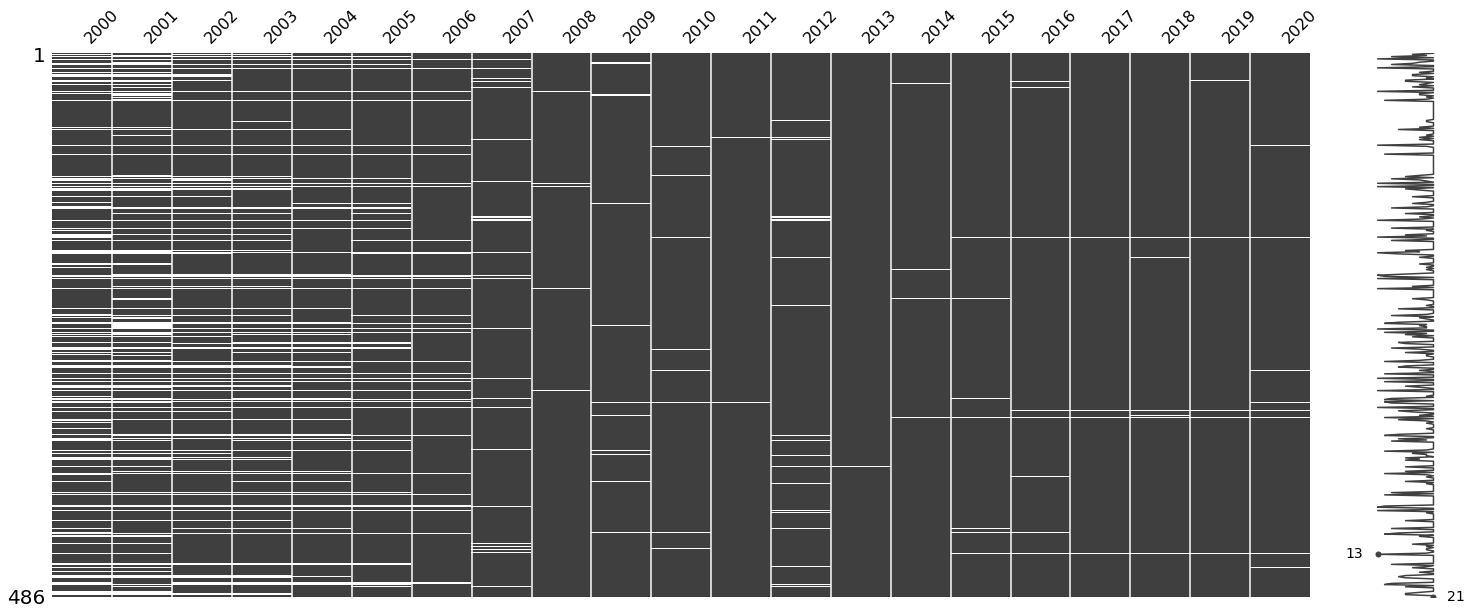

In [149]:
# Plot - Mapa de Valores Ausentes
dat_nan = pd.DataFrame(dat_clean.isna().sum())

if dat_clean.isna().any(axis = None):
    missingno.matrix(dat_clean[dat_nan[dat_nan[0]>0].index])
    plt.show()

In [150]:
# Contar as linhas com valores ausentes
missing_rows = sum([True for idx,row in dat_clean.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes". format(missing_rows))

Temos 172 linhas com valores ausentes


In [175]:
m = dat_clean.mean(axis=1)
for i, column in enumerate(dat_clean):
    dat_clean.iloc[:, i] = dat_clean.iloc[:, i].fillna(m)

In [152]:
dat_clean.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,3500105,Adamantina (SP),50000.000000,80000.000000,76311.000000,77794.000000,80000.000000,81307.000000,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
2,3500204,Adolfo (SP),88833.833333,80000.000000,88833.833333,88833.833333,120000.000000,89009.000000,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
3,3500303,Aguaí (SP),80000.000000,88180.150000,87000.000000,86089.000000,86000.000000,85434.000000,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
6,3500550,Águas de Santa Bárbara (SP),80132.266667,80132.266667,80132.266667,80132.266667,80132.266667,80132.266667,80333.0,80000.0,...,80000.0,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0
8,3500709,Agudos (SP),70000.000000,70000.000000,70000.000000,70000.000000,77996.000000,77723.000000,80000.0,88669.0,...,79500.0,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0


In [153]:
# Contar as linhas com valores ausentes
missing_rows = sum([True for idx,row in dat_clean.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes". format(missing_rows))

Temos 0 linhas com valores ausentes


In [169]:
dat_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 1 to 642
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Cód.       486 non-null    object 
 1   Município  486 non-null    object 
 2   2000       486 non-null    float64
 3   2001       486 non-null    float64
 4   2002       486 non-null    float64
 5   2003       486 non-null    float64
 6   2004       486 non-null    float64
 7   2005       486 non-null    float64
 8   2006       486 non-null    float64
 9   2007       486 non-null    float64
 10  2008       486 non-null    float64
 11  2009       486 non-null    float64
 12  2010       486 non-null    float64
 13  2011       486 non-null    float64
 14  2012       486 non-null    float64
 15  2013       486 non-null    float64
 16  2014       486 non-null    float64
 17  2015       486 non-null    float64
 18  2016       486 non-null    float64
 19  2017       486 non-null    float64
 20  2018      

Assim finalizamos a primeira parte da nossa análise

#### Parte 2: 